## CPSC 7260 Presentation:
## Universal probabilistic programming offers a powerful approach to statistical phylogenetics 

Anna Su

11/19/2025

In [1]:
import treeppl
%load_ext treeppl.ipython

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from Bio import Phylo

sns.set_theme()

### Generating a CRBD tree

**What this cell does**:
This section defines a generative constant-rate birth-death (CRBD) tree model in TreePPL. The function `generativeCrbd(time, lambda, mu)` returns a `Tree` sampled from a birth-death process run for `time` units with speciation rate `lambda` and extinction rate `mu`.

**Inputs**:
- `time` (Real): remaining time to simulate backwards from the present.
- `lambda` (Real): speciation (birth) rate.
- `mu` (Real): extinction (death) rate.

**Behavior (summary)**:
1. Draw a waiting time from Exponential(lambda + mu) to the next event (speciation or extinction).
2. If the event occurs before time runs out, decide whether it is a speciation (Bernoulli with prob lambda/(lambda+mu)).
   - If speciation: recurse to produce a `Node` with two descendant subtrees.
   - If extinction: return a `Leaf` at the time of the event.
3. If no event occurs within `time`, return a `Leaf` with age 0.0 (no further events).

**Notes**:
- This is a recursive generative model; the recursion depth depends on the realized speciation events.
- The cell below contains the executable TreePPL model.

In [3]:
%%treeppl generative_crbd samples=1

model function generativeCrbd(time: Real, lambda: Real, mu: Real) => Tree {
  assume waitingTime ~ Exponential(lambda + mu);
  let eventTime = time - waitingTime;
  if eventTime < 0.0 {
    return Leaf {age = 0.0};
  } else {
    assume isSpeciation ~ Bernoulli(lambda / (lambda + mu));
    if isSpeciation {
      return Node {
        left = generativeCrbd(eventTime, lambda, mu),
        right = generativeCrbd(eventTime, lambda, mu),
        age = eventTime
      };
    } else {
      return Leaf {age = eventTime};
    }
  }
}

**How to sample and visualize a generated tree**:
This cell runs the `generative_crbd` model defined above with concrete parameter values and shows one sampled tree.

- `generative_crbd(**params)` returns an object with `samples` (the sampled trees) and `norm_const` / weights.
- We extract the first sample `result.samples[0]`, convert it to a Biopython-compatible clade using `to_biopython()` and draw it with `Phylo.draw`.

**Tip**: change `params['time']`, `lambda`, and `mu` to explore different regimes (e.g., high extinction vs low extinction).

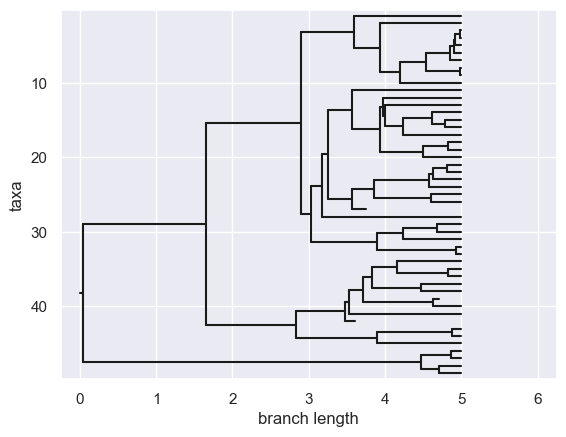

In [5]:
params = {
    "time": 5.0,
    "lambda": 1.0,
    "mu": 0.1
}

result = generative_crbd(**params)
tree = result.samples[0]
tree = Phylo.BaseTree.Clade(
    branch_length=params["time"] - tree.age,
    clades=[tree.to_biopython()],
)
Phylo.draw(tree)

### Inferring parameters of a CRBD model

**Overview of the inference code below**:
This part defines an importance-sampling (weighted) / SMC-style model to infer `lambda` and `mu` given an observed tree. The supporting functions: `simulateExtinctSubtree`, `simulateUnobservedSpeciations`, and `walk` are used to compute the conditional likelihood (with weights) of the observed reconstructed tree under the CRBD model.

**Functions**:
- `simulateExtinctSubtree(time, lambda, mu)`: simulates subtree lineages that go extinct within `time` — used to account for unobserved lineages when conditioning on the observed tree. If no extinction occurs (waiting time > time) this trajectory is discarded (weight 0).
- `simulateUnobservedSpeciations(node, time, lambda, mu)`: simulates hidden speciation events along an observed branch and increments the importance weight when such events are compatible with the observation.
- `walk(node, time, lambda, mu)`: walks the observed tree recursively, calling the above helpers and observing events consistent with branch lengths.

**Model `crbd(tree)`**:
- Places priors on `lambda` and `mu` (Gamma priors here).
- Runs `walk` on the two descendants of the root to compute the likelihood weight.
- Returns the parameter vector `[lambda, mu]` which can be collected as weighted samples.

In [6]:
%%treeppl crbd samples=10000 subsamples=10

function simulateExtinctSubtree(time: Real, lambda: Real, mu: Real) {
  assume waitingTime ~ Exponential(lambda + mu);
  if waitingTime > time {
    weight 0.0; resample;
  } else {
    assume isSpeciation ~ Bernoulli(lambda / (lambda + mu));
    if isSpeciation {
      simulateExtinctSubtree(time - waitingTime, lambda, mu);
      simulateExtinctSubtree(time - waitingTime, lambda, mu);
    }
  }
}

function simulateUnobservedSpeciations(node: Tree, time: Real, lambda: Real, mu: Real) {
  assume waitingTime ~ Exponential(lambda);
  if time - waitingTime > node.age {
    simulateExtinctSubtree(time - waitingTime, lambda, mu);
    weight 2.0;
    simulateUnobservedSpeciations(node, time - waitingTime, lambda, mu);
  }
}

function walk(node: Tree, time:Real, lambda: Real, mu: Real) {
  simulateUnobservedSpeciations(node, time, lambda, mu);
  observe 0 ~ Poisson(mu * (time - node.age));
  if node is Node {
    observe 0.0 ~ Exponential(lambda);
    walk(node.left, node.age, lambda, mu);
    walk(node.right, node.age, lambda, mu);
  }
}

model function crbd(tree: Tree) => Real[] {
  assume lambda ~ Gamma(1.0, 1.0);
  assume mu ~ Gamma(1.0, 0.5);
  walk(tree.left, tree.age, lambda, mu);
  walk(tree.right, tree.age, lambda, mu);
  return [lambda, mu];
}

**Collecting weighted samples and visualizing posteriors**:
This loop calls the `crbd` inference model repeatedly to collect weighted samples of `(lambda, mu)`. Each call returns a sample plus a log-weight (importance weight stored in `res.norm_const`).

**What the code does**:
- Loads an observed tree from `trees/Accipitridae.tre.phyjson`.
- Calls `crbd(tree=...)` in a loop and appends samples and their log-weights into a DataFrame.
- Converts log-weights to normalized weights for plotting via exponential re-scaling: `exp(lweight - lweight.max())`.
- Plots kernel density estimates for `lambda` and `mu` using these weights.

**Notes & tips**:
- The number of iterations (here up to 1000) and `%%treeppl samples=10000 subsamples=10` defined in the previous cell control the statistical accuracy and runtime.
- If plotting seems slow, reduce the plotting frequency or number of iterations.
- Save `samples` to disk for later analysis instead of re-running the loop.

In [ ]:
alcedinidae = treeppl.Tree.load("trees/Accipitridae.tre.phyjson", format="phyjson")

samples = None
for i in range(100):
    try:
        res = crbd(tree=alcedinidae)
        samples = pd.concat([
            samples,
            pd.DataFrame({
                "lambda": res.items(0), "mu": res.items(1), "lweight": res.norm_const
            })
        ])
        weights = np.exp(samples.lweight - samples.lweight.max())
        clear_output(wait=True)
        sns.kdeplot(data=samples, x="lambda", weights=weights, label="lambda")
        sns.kdeplot(data=samples, x="mu", weights=weights, label="mu")
        plt.legend()
        plt.xlim(0, 0.5)
        plt.ylim(0, 100)
        plt.pause(0.05)
    except KeyboardInterrupt:
        break

FileNotFoundError: [Errno 2] No such file or directory: 'treeppl/trees/Accipitridae.tre.phyjson'